<center><h1 style="font-size:40px;">Exercise III:<br> Image Classification using CNNs</h1></center>

---

Welcome to the *fourth* lab for Deep Learning!

In this lab an CNN network to classify RGB images. Image classification refers to classify classes from images. This labs the *dataset* consist of multiple images where each image have a target label for classification.

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!


Good luck!

---

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to acces the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('')))

In [2]:
# Torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# local modules
from torch.utils.data import DataLoader
from utils.progressbar import LitProgressBar
from utils.dataset import ClassificationDataset
from utils.model import Model
from config import LabConfig
from collections import OrderedDict
from utils import plot
import pprint
import torchmetrics
import pytorch_lightning as pl
import torchvision

import pandas as pd
import matplotlib.pyplot as plt

from torchmetrics import Precision
import numpy as np

# Load config

In [3]:
cfg = LabConfig()
cfg.todict()

{'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'fineGrained': False,
 'NUM_CLASSES': 4,
 'training_img_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_img_dir': '../data/FlyingObjectDataset_10K/validation',
 'testing_img_dir': '../data/FlyingObjectDataset_10K/testing',
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

# Example Task
First we present an example task to get an idea of the implementation and how to structure the code.

## Example data
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at the [pytorch doc](https://pytorch.org/vision/stable/transforms.html)

Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader.

### Augmentation

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), #, 
])

### Create dataloaders

In [25]:
train_dataloader = DataLoader(ClassificationDataset(cfg.training_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(ClassificationDataset(cfg.validation_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

test_dataloader = DataLoader(ClassificationDataset(cfg.testing_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we visualise the data. 

x (32, 3, 128, 128) torch.float32 0.0 1.0
y (32,) torch.int64 0 2


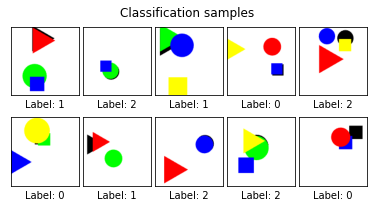

In [6]:
t_x, t_y = next(iter(train_dataloader))
print(f"x {tuple(t_x.shape)} {t_x.dtype} {t_x.min()} {t_x.max()}")
print(f"y {tuple(t_y.shape)} {t_y.dtype} {t_y.min()} {t_y.max()}")
plot.Classification.data(t_x, t_y, nimages=10,nrows=2)

In [7]:
if False: # Set to true to visualise statistics of the data
    plot.show_statistics(cfg.training_img_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
    plot.show_statistics(cfg.validation_img_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
    plot.show_statistics(cfg.testing_img_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")

## Create model
Here is an simple architecture to train our network.

In [8]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64) # Calculated with the size. why //4
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

## Config

In [9]:
# Train model
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(), # error function
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

## Train

In [10]:
# Load model
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR, name='Example'),
            callbacks=[LitProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )
# Train with the training and validation data- 
trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/d/denmar20/.conda/envs/deepl

/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1805: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  rank_zero_deprecation(


## Test the network on the test dataset
To test the performance for a qualitative estimation we can plot the input, target and the models prediction. This is a good approach to see the performance and understand if the model is close to a correct decision. However, for big data, we probobly want to focus on a qualitative estimation. Therefore we can analyse **Tensorboard** logs to get a better understanding of the model.

In [11]:
# Create iterable from the test dataset
iter_dataloader = iter(test_dataloader)

In [12]:
# Take one batch from the test dataset and predict!
X, Y = next(iter_dataloader)
preds = torch.argmax(modelObj.predict_step(X,0,0),dim=1)

In [13]:
n_test = 10
df_result = pd.DataFrame({
    'Ground Truth': Y[:n_test],
    'Predicted label': preds[:n_test]})
display(df_result.T)

,0,1,2,3,4,5,6,7,8,9
Ground Truth,1,1,0,0,0,0,0,1,1,0
Predicted label,1,0,1,2,2,0,0,0,1,0


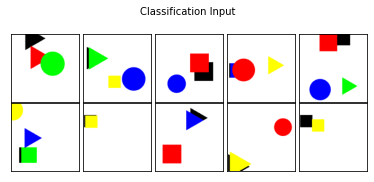

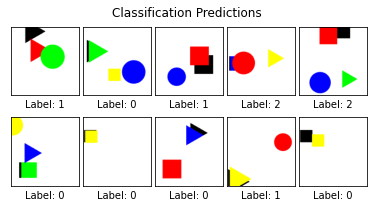

In [14]:
plot.Classification.results(X, preds)

# Exercises

## Metrics
**TODO:** Does a high accuracy impy a good model, motivate your answer.

**TODO:** Find an alternative metric which can show similar or better precision than accuracy.

In [15]:
# Task 1

x_train, y_train = next(iter(train_dataloader))
train_preds = torch.argmax(modelObj.predict_step(x_train, 0, 0), dim = 1)

x_test, y_test = next(iter(test_dataloader))
preds = torch.argmax(modelObj.predict_step(x_test, 0, 0), dim = 1)

print('train acc: ' + str(np.mean(y_train.numpy() == train_preds.numpy())*100))
print('test acc: ' + str(np.mean(y_test.numpy() == preds.numpy())*100))

train acc: 100.0
test acc: 34.375


In [16]:
# Task 2

precision = Precision(num_classes=cfg.todict()['NUM_CLASSES'])

print(precision(train_preds, y_train))
print(precision(preds, y_test))

tensor(1.)
tensor(0.3438)


## Architecture
Modify the architecture of the SimpleModel to further increase the performance. Remember that very deep network allow the network to learn many features but if the dataset is to small the model will underfit. A simple dataset should not require a very deep network to learn good features.

**TODO:** Modify the SimpleModel architecture. Force the network to overfit. How bad performance can you get from the network?

**TODO:** Modify the SimpleModel and increase the complexity a little. Does the performance improve? If not, did you modify it to much or to little?

**TODO:** Modify the SimpleModel architecture. Now combine the hyperparameter tuning and modification of the architecture to reach a performance that is close to the truth images. Explain in detail why the change was applied and if it improved the model a lot.

In [17]:
# Task 1

config = {
    'drop':0.5,
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(),
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(64*input_shape[1]//4*input_shape[1]//4, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=11, padding=5)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1

        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
       
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)

        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out
    
def train():
    # Load model
    modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)
     
    # Setup trainer
    trainer = pl.Trainer(
                max_epochs=config['max_epochs'], 
                gpus=1,
                logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR, name='Architecture1'),
                callbacks=[pl.callbacks.progress.TQDMProgressBar()],
                progress_bar_refresh_rate=1,
                weights_summary=None,
                num_sanity_val_steps=10,   
            )

    trainer.fit(
        modelObj, 
        train_dataloader=train_dataloader,
        val_dataloaders=valid_dataloader
    );
    
train()

x_train, y_train = next(iter(train_dataloader))
train_preds = torch.argmax(modelObj.predict_step(x_train, 0, 0), dim = 1)

x_test, y_test = next(iter(test_dataloader))
preds = torch.argmax(modelObj.predict_step(x_test, 0, 0), dim = 1)

print('train acc: ' + str(np.mean(y_train.numpy() == train_preds.numpy())*100))
print('test acc: ' + str(np.mean(y_test.numpy() == preds.numpy())*100))

/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
/home/stud/d/denmar20/.conda/envs/deeplearn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:167: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stud/d/denmar20/.conda/envs/deepl

Epoch 0:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 339/410 [00:10<00:02, 32.68it/s, loss=1.37, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 339/410 [00:10<00:02, 32.45it/s, loss=1.04, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 339/410 [00:10<00:02, 32.78it/s, loss=0.34, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 339/410 [00:10<00:02, 31.97it/s, loss=0.0519, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 3:  84%|██████████████████████████████████████████

Epoch 4:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 339/410 [00:10<00:02, 31.75it/s, loss=0.109, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:12<00:00, 32.50it/s, loss=0.109, v_num=3]
train acc: 96.875
test acc: 37.5


In [18]:
# Task 2

config = {
    'drop':0.5,
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(),
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        conv_layers = 4
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.conv_layer3 = self._conv_layer_set(64, 72)
        self.conv_layer4 = self._conv_layer_set(72, 90)        
                        
        self.fc1 = nn.Linear(90*input_shape[1]//np.power(2, conv_layers)*input_shape[1]//np.power(2, conv_layers), 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1
        
        
        out = self.conv_layer1(x)      
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
                               
        
        return out
    
def train():
    # Load model
    modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)
     
    # Setup trainer
    trainer = pl.Trainer(
                max_epochs=config['max_epochs'], 
                gpus=1,
                logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR, name='Architecture2'),
                callbacks=[pl.callbacks.progress.TQDMProgressBar()],
                progress_bar_refresh_rate=1,
                weights_summary=None,
                num_sanity_val_steps=10,   
            )

    trainer.fit(
        modelObj, 
        train_dataloader=train_dataloader,
        val_dataloaders=valid_dataloader
    );
    
train()

x_train, y_train = next(iter(train_dataloader))
train_preds = torch.argmax(modelObj.predict_step(x_train, 0, 0), dim = 1)

x_test, y_test = next(iter(test_dataloader))
preds = torch.argmax(modelObj.predict_step(x_test, 0, 0), dim = 1)

print('train acc: ' + str(np.mean(y_train.numpy() == train_preds.numpy())*100))
print('test acc: ' + str(np.mean(y_test.numpy() == preds.numpy())*100))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 339/410 [00:05<00:01, 63.78it/s, loss=0.429, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 339/410 [00:05<00:01, 63.36it/s, loss=0.117, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 339/410 [00:05<00:01, 63.35it/s, loss=0.323, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 339/410 [00:05<00:01, 62.49it/s, loss=0.0844, v_num=3]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|██████████████████████████████████████████

Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:06<00:00, 64.90it/s, loss=0.108, v_num=3]
train acc: 100.0
test acc: 34.375


In [26]:
# Task 3

config = {
    'drop':0.5,
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.005,
        }
    },
    'criterion':torch.nn.CrossEntropyLoss(),
    'max_epochs':5,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        conv_layers = 6
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.conv_layer3 = self._conv_layer_set(64, 72)
        self.conv_layer4 = self._conv_layer_set(72, 100)
        self.conv_layer5 = self._conv_layer_set(100, 128)
        self.conv_layer6 = self._conv_layer_set(128, 150)        
                        
        self.fc1 = nn.Linear(150*input_shape[1]//np.power(2, conv_layers)*input_shape[1]//np.power(2, conv_layers), 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.5)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=11, padding=5)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1
        
        
        out = self.conv_layer1(x)      
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.conv_layer5(out)
        out = self.conv_layer6(out)
        
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
                               
        
        return out
    
def train():
    # Load model
    modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config)
     
    # Setup trainer
    trainer = pl.Trainer(
                max_epochs=config['max_epochs'], 
                gpus=1,
                logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR, name='Architecture3'),
                callbacks=[pl.callbacks.progress.TQDMProgressBar()],
                progress_bar_refresh_rate=1,
                weights_summary=None,
                num_sanity_val_steps=10,   
            )

    trainer.fit(
        modelObj, 
        train_dataloader=train_dataloader,
        val_dataloaders=valid_dataloader
    );
    
train()

x_train, y_train = next(iter(train_dataloader))
train_preds = torch.argmax(modelObj.predict_step(x_train, 0, 0), dim = 1)

x_test, y_test = next(iter(test_dataloader))
preds = torch.argmax(modelObj.predict_step(x_test, 0, 0), dim = 1)

print('train acc: ' + str(np.mean(y_train.numpy() == train_preds.numpy())*100))
print('test acc: ' + str(np.mean(y_test.numpy() == preds.numpy())*100))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.68it/s, loss=1.85e+03, v_num=10]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 340/410 [00:16<00:03, 20.42it/s, loss=120, v_num=10]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:16<00:03, 20.31it/s, loss=4.47, v_num=10]
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 350/410 [00:17<00:02, 20.37it/s, loss=4.47, v_num=10]


Epoch 3:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:16<00:03, 20.20it/s, loss=2.09, v_num=10]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:16<00:03, 20.18it/s, loss=1.37, v_num=10]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 375/410 [00:17<00:01, 20.99it/s, loss=1.37, v_num=10]


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:19<00:00, 20.85it/s, loss=1.37, v_num=10]
train acc: 100.0
test acc: 87.5


## Hyperparameter tuning
### Task 1
From the example approach we can see that the network performed very poorly. For the network to be consider "good" the truth images should match the predicted images. If the architecture can learn but is unstable (check loss/epoch in tensorboard), it is possible to tune the parameters of the network. This mostly involves changing the learning rate, optimizers, loss function etc. to better learn features. A network that have a to high learning rate create a increase in variance of the network weights which can make the network unstable.


**TODO:** Perform hyperparameter tuning. Explain in detail why the parameters was changed and why it is considered "better".

In [27]:
class SimpleModel(nn.Module):
    def __init__(self,num_channels:int=4, num_classes:int=3, input_shape=(10,10),**kwargs):
        super().__init__()
        conv_layers = 6
        self.conv_layer1 = self._conv_layer_set(num_channels, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.conv_layer3 = self._conv_layer_set(64, 72)
        self.conv_layer4 = self._conv_layer_set(72, 100)
        self.conv_layer5 = self._conv_layer_set(100, 128)
        self.conv_layer6 = self._conv_layer_set(128, 150) 
        
        
        feedforward = []
        
        self.fc1 = nn.Linear(150*input_shape[1]//np.power(2, conv_layers)*input_shape[1]//np.power(2, conv_layers), 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.75)
        
        
        feedforward.append(self.fc1)
        feedforward.append(self.drop)
        feedforward.append(self.fc2)
            
        
        self.ffd = nn.Sequential(*feedforward)
        print(self.ffd)
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(OrderedDict([
            ('conv',nn.Conv2d(in_c, out_c, kernel_size=11, padding=5)),
            ('leakyrelu',nn.LeakyReLU()),
            ('maxpool',nn.MaxPool2d(2)),
        ]))
        return conv_layer
    

    def forward(self, x):
        # Set 1
        
        out = self.conv_layer1(x)      
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.conv_layer5(out)
        out = self.conv_layer6(out)
        
        out = out.view(out.size(0), -1) # Flatten (batchsize, image size)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

    
config = {
    'drop':0.75,
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":0.0001,
            'weight_decay': 0.0001

        }
    },
    'criterion':torch.nn.CrossEntropyLoss(),
    'max_epochs':50,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
        torchmetrics.F1(num_classes=cfg.NUM_CLASSES,compute_on_step=False),
    ],postfix="_Validation")
}

modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config) 

trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR, name='Hypertuning'),
            callbacks=[pl.callbacks.progress.TQDMProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None, # Can be None, top or full
            num_sanity_val_steps=10,   
        )

trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sequential(
  (0): Linear(in_features=600, out_features=64, bias=True)
  (1): Dropout(p=0.75, inplace=False)
  (2): Linear(in_features=64, out_features=4, bias=True)
)
Epoch 0:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 340/410 [00:16<00:03, 20.41it/s, loss=1.15, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 340/410 [00:16<00:03, 20.22it/s, loss=1.13, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:17<00:03, 19.95it/s, loss=0.464, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 3:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 340/410 [00:16<00:03, 20.08it/s, loss=0.23, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:16<00:03, 20.10it/s, loss=0.0978, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 375/410 [00:17<00:01, 20.92it/s, loss=0.0978, v_num=7]


Epoch 5:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:17<00:03, 19.98it/s, loss=0.0356, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:17<00:03, 19.99it/s, loss=0.101, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 400/410 [00:18<00:00, 21.49it/s, loss=0.101, v_num=7]


Epoch 7:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:16<00:03, 20.02it/s, loss=0.105, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:16<00:03, 20.08it/s, loss=0.0439, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 9:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:17<00:03, 19.98it/s, loss=0.0114, v_num=7]
Validating: 0it [00:00, ?it/s]


Epoch 10:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.97it/s, loss=0.0147, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.96it/s, loss=0.00458, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 11:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 360/410 [00:17<00:02, 20.34it/s, loss=0.00458, v_num=7]


Epoch 12:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.99it/s, loss=0.00851, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 13:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.96it/s, loss=0.0261, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 13:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 385/410 [00:18<00:01, 21.06it/s, loss=0.0261, v_num=7]


Epoch 14:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.97it/s, loss=0.00149, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 15:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:16<00:03, 20.02it/s, loss=0.00127, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 21.79it/s, loss=0.00127, v_num=7]


Epoch 16:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 20.00it/s, loss=4.15e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 17:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.99it/s, loss=0.0001, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 18:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:17<00:03, 19.86it/s, loss=0.012, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 18:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 345/410 [00:17<00:03, 19.78it/s, loss=0.012, v_num=7]


Epoch 19:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.92it/s, loss=0.0254, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 20:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.97it/s, loss=0.00182, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 20:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 365/410 [00:17<00:02, 20.49it/s, loss=0.00182, v_num=7]


Epoch 21:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.98it/s, loss=0.0136, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 22:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.90it/s, loss=0.000635, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 22:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 395/410 [00:18<00:00, 21.26it/s, loss=0.000635, v_num=7]


Epoch 23:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.05it/s, loss=0.000946, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 24:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.99it/s, loss=0.000319, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 25:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:16<00:03, 20.01it/s, loss=0.0757, v_num=7]


Validating: 0it [00:00, ?it/s]
Epoch 26:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.99it/s, loss=0.00029, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 27:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.89it/s, loss=0.0137, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 27:  87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 355/410 [00:17<00:02, 20.11it/s, loss=0.0137, v_num=7]


Epoch 28:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.95it/s, loss=0.000727, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 29:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.06it/s, loss=5.38e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 29:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 380/410 [00:18<00:01, 20.97it/s, loss=5.38e-05, v_num=7]


Epoch 30:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:16<00:03, 20.00it/s, loss=3.2e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 31:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.00it/s, loss=4.47e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 31:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 405/410 [00:18<00:00, 21.64it/s, loss=4.47e-05, v_num=7]


Epoch 32:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:16<00:03, 20.15it/s, loss=0.0546, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 33:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.92it/s, loss=0.000309, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 34:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.93it/s, loss=0.000317, v_num=7]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                                    | 0/71 [00:00<?, ?it/s]


Epoch 35:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.93it/s, loss=0.000706, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 36:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.06it/s, loss=0.000165, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 36:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 365/410 [00:17<00:02, 20.57it/s, loss=0.000165, v_num=7]


Epoch 37:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.01it/s, loss=0.000169, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 38:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 20.00it/s, loss=0.0244, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 38:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 390/410 [00:18<00:00, 21.23it/s, loss=0.0244, v_num=7]


Epoch 39:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.08it/s, loss=0.000172, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 40:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:16<00:03, 20.08it/s, loss=0.0299, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 21.74it/s, loss=0.0299, v_num=7]


Epoch 41:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.91it/s, loss=0.00106, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 42:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.94it/s, loss=0.0022, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 43:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.92it/s, loss=0.000521, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 43:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 350/410 [00:17<00:03, 19.98it/s, loss=0.000521, v_num=7]


Epoch 44:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:16<00:03, 20.14it/s, loss=0.00023, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 45:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.01it/s, loss=1.61e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 45:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 370/410 [00:17<00:01, 20.66it/s, loss=1.61e-05, v_num=7]


Epoch 46:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.98it/s, loss=9.91e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 47:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.03it/s, loss=3.86e-05, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 47:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 400/410 [00:18<00:00, 21.54it/s, loss=3.86e-05, v_num=7]


Epoch 48:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.12it/s, loss=8.33e-06, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 49:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.99it/s, loss=0.0585, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:19<00:00, 20.77it/s, loss=0.0585, v_num=7]


In [28]:
x_test, y_test = next(iter(test_dataloader))
preds = torch.argmax(modelObj.predict_step(x_test, 0, 0), dim=1)
print('test acc: ' + str(np.mean(y_test.numpy() == preds.numpy())*100))

test acc: 87.5


## Augmentation
**TODO:** Test if data augmentation help. Note that if we want to apply augmentation we need to make sure that the input and target perform the same augmentation. Otherwise, the data will not be correct!

**Question:** Did data augmentation improve the model? \
**Question:** What do you think have the greatest impact on the performance, why? \

In [29]:
# Task 1

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(0.3),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), 
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)), 
])

train_dataloader = DataLoader(ClassificationDataset(cfg.training_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=train_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=True,
                        num_workers=cfg.NUM_WORKERS)
valid_dataloader = DataLoader(ClassificationDataset(cfg.validation_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

test_dataloader = DataLoader(ClassificationDataset(cfg.testing_img_dir, cfg.CLASSES, img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),transform=test_transform),
                        batch_size=cfg.BATCH_SIZE,
                        shuffle=False,
                        num_workers=cfg.NUM_WORKERS)

In [30]:
modelObj = Model(SimpleModel(num_classes=cfg.NUM_CLASSES, num_channels=cfg.IMAGE_CHANNEL, input_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),**config) 

trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR, name='Augmentation'),
            callbacks=[pl.callbacks.progress.TQDMProgressBar()],
            progress_bar_refresh_rate=1,
            weights_summary=None,
            num_sanity_val_steps=10,   
        )

trainer.fit(
    modelObj, 
    train_dataloader=train_dataloader,
    val_dataloaders=valid_dataloader
);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sequential(
  (0): Linear(in_features=600, out_features=64, bias=True)
  (1): Dropout(p=0.75, inplace=False)
  (2): Linear(in_features=64, out_features=4, bias=True)
)
Epoch 0:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 339/410 [00:16<00:03, 20.01it/s, loss=1.15, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 340/410 [00:16<00:03, 20.01it/s, loss=1.13, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 340/410 [00:17<00:03, 19.85it/s, loss=1.12, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 2:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████

Epoch 3:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:17<00:03, 19.89it/s, loss=0.473, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:16<00:03, 20.05it/s, loss=0.199, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 375/410 [00:18<00:01, 20.82it/s, loss=0.199, v_num=4]


Epoch 5:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:16<00:03, 20.07it/s, loss=0.0599, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:17<00:03, 19.96it/s, loss=0.038, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 6:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 400/410 [00:18<00:00, 21.47it/s, loss=0.038, v_num=4]


Epoch 7:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:17<00:03, 19.87it/s, loss=0.0485, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 8:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:17<00:03, 19.96it/s, loss=0.0153, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 9:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.99it/s, loss=0.00865, v_num=4]
Validating: 0it [00:00, ?it/s]


Epoch 10:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.94it/s, loss=0.00511, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 11:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 20.00it/s, loss=0.00452, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 11:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 360/410 [00:17<00:02, 20.38it/s, loss=0.00452, v_num=4]


Epoch 12:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.97it/s, loss=0.0134, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 13:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:16<00:03, 20.02it/s, loss=0.00126, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 13:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 385/410 [00:18<00:01, 21.10it/s, loss=0.00126, v_num=4]


Epoch 14:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:16<00:03, 20.10it/s, loss=0.00643, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 15:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.94it/s, loss=0.00504, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 21.68it/s, loss=0.00504, v_num=4]


Epoch 16:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:16<00:03, 20.04it/s, loss=0.0173, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 17:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:16<00:03, 20.04it/s, loss=0.0232, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 18:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:16<00:03, 20.06it/s, loss=0.0315, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 18:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 345/410 [00:17<00:03, 19.97it/s, loss=0.0315, v_num=4]


Epoch 19:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.92it/s, loss=0.0139, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 20:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 340/410 [00:17<00:03, 19.91it/s, loss=0.15, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 20:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 370/410 [00:17<00:01, 20.59it/s, loss=0.15, v_num=4]


Epoch 21:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.97it/s, loss=0.000634, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 22:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 340/410 [00:17<00:03, 19.88it/s, loss=0.032, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 22:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 395/410 [00:18<00:00, 21.23it/s, loss=0.032, v_num=4]


Epoch 23:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.90it/s, loss=0.00156, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 24:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.92it/s, loss=0.000105, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 25:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.90it/s, loss=0.00369, v_num=4]


Validating: 0it [00:00, ?it/s]
Epoch 26:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.89it/s, loss=0.000827, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 27:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.06it/s, loss=0.000114, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 27:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 355/410 [00:17<00:02, 20.28it/s, loss=0.000114, v_num=4]


Epoch 28:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.97it/s, loss=0.000114, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 29:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.87it/s, loss=5.13e-05, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 29:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 375/410 [00:18<00:01, 20.69it/s, loss=5.13e-05, v_num=4]


Epoch 30:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.91it/s, loss=0.0568, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.88it/s, loss=0.0209, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 31:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 405/410 [00:18<00:00, 21.52it/s, loss=0.0209, v_num=4]


Epoch 32:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.93it/s, loss=0.000163, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 33:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.04it/s, loss=0.000356, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 34:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.04it/s, loss=0.000177, v_num=4]
Validating: 0it [00:00, ?it/s]
Validating:   0%|                                                                                                                                                                    | 0/71 [00:00<?, ?it/s]


Epoch 35:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.95it/s, loss=3.44e-05, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.99it/s, loss=6.91e-06, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 36:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 365/410 [00:17<00:02, 20.50it/s, loss=6.91e-06, v_num=4]


Epoch 37:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.02it/s, loss=1.01e-05, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.86it/s, loss=0.00551, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 38:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 390/410 [00:18<00:00, 21.08it/s, loss=0.00551, v_num=4]


Epoch 39:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.91it/s, loss=0.0661, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 40:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.94it/s, loss=0.00287, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 40: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:18<00:00, 21.60it/s, loss=0.00287, v_num=4]


Epoch 41:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.85it/s, loss=0.00934, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 42:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.88it/s, loss=0.00242, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 43:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 340/410 [00:17<00:03, 19.90it/s, loss=0.0017, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 43:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 350/410 [00:17<00:03, 19.97it/s, loss=0.0017, v_num=4]


Epoch 44:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.87it/s, loss=0.000384, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 45:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.81it/s, loss=0.000194, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 45:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 375/410 [00:18<00:01, 20.60it/s, loss=0.000194, v_num=4]


Epoch 46:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 340/410 [00:17<00:03, 19.93it/s, loss=0.00327, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 47:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.82it/s, loss=0.000219, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 47:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 400/410 [00:18<00:00, 21.30it/s, loss=0.000219, v_num=4]


Epoch 48:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:17<00:03, 19.91it/s, loss=0.000463, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 49:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 340/410 [00:16<00:03, 20.05it/s, loss=0.000128, v_num=4]
Validating: 0it [00:00, ?it/s]
Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 410/410 [00:20<00:00, 20.50it/s, loss=0.000128, v_num=4]


In [32]:
x_test, y_test = next(iter(test_dataloader))
preds = torch.argmax(modelObj.predict_step(x_test, 0, 0), dim=1)
print('test acc: ' + str(np.mean(y_test.numpy() == preds.numpy())*100))

test acc: 87.5
